# Setting Up

In [1]:
from fastai.vision.all import *
from fastai.metrics import *
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

In [2]:
fnames = get_image_files('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1') + get_image_files('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2')
len(fnames)

10015

In [3]:
lbl_names = get_image_files('/kaggle/input/masks/HAM10000_segmentations_lesion_tschandl')
len(lbl_names)

10015

# Display of Ground Truth Mask

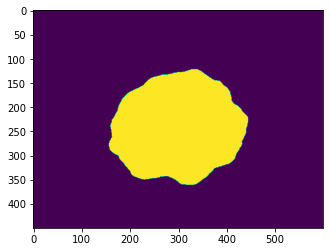

In [4]:
img = Image.open(lbl_names[0])
plt.imshow(img)

# Loading labels

In [5]:
codes = ['Background', 'Face']

In [6]:
src_size = np.array(img.shape[1:])
src_size

array([600])

# Conversion of mask into Fastai's

In [7]:
def n_codes(fnames, is_partial=True):
  "Gather the codes from a list of `fnames`"
  vals = set()
  if is_partial:
    random.shuffle(fnames)
    fnames = fnames[:10]
  for fname in fnames:
    msk = np.array(PILMask.create(fname))
    for val in np.unique(msk):
      if val not in vals:
        vals.add(val)
  vals = list(vals)
  p2c = dict()
  for i,val in enumerate(vals):
    p2c[i] = vals[i]
  return p2c

In [8]:
p2c = n_codes(lbl_names)

In [9]:
p2c

{0: 0, 1: 255}

In [10]:
def get_msk(fn, p2c):
  "Grab a mask from a `filename` and adjust the pixels based on `pix2class`"
  fn = Path('/kaggle/input/masks/HAM10000_segmentations_lesion_tschandl')/f'{fn.stem}_segmentation.png'
  msk = np.array(PILMask.create(fn))
  mx = np.max(msk)
  for i, val in enumerate(p2c):
    msk[msk==p2c[i]] = val
  return PILMask.create(msk)

In [11]:
get_y = lambda o: get_msk(o, p2c)

# IOU Metric

In [12]:
name2id = {v:k for k,v in enumerate(codes)}

def iou(input, target):
    target = target.squeeze(1)
    mask = target != 0
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [13]:
size = src_size//4
size


array([150])

# Defining Model

In [14]:
skin = DataBlock(blocks=(ImageBlock, MaskBlock(codes = codes)),
    get_items=get_image_files,
    splitter=RandomSplitter(),
    get_y=get_y,
    item_tfms=Resize(150),
    batch_tfms=[Normalize.from_stats(*imagenet_stats)])

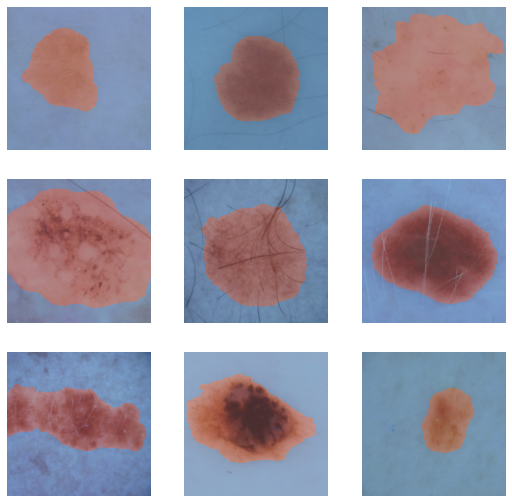

In [15]:
path = '/kaggle/input/skin-cancer-mnist-ham10000/'
dls = skin.dataloaders(path, bs=64)
dls.show_batch()

# Training - 1

In [16]:
learn=unet_learner(dls, resnet18, metrics=iou)
learn.fine_tune(10)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,iou,time
0,0.144059,0.124273,0.939940,10:07


epoch,train_loss,valid_loss,iou,time
0,0.099093,0.102016,0.926493,08:15
1,0.084062,0.094204,0.939907,08:06
2,0.080858,0.082780,0.943461,08:19
3,0.069856,0.075941,0.960579,08:07
4,0.060868,0.071173,0.952996,08:05
5,0.054496,0.064283,0.960178,08:00
6,0.045754,0.060624,0.964288,08:00
7,0.041003,0.057590,0.969025,08:01
8,0.037427,0.058729,0.964059,08:08
9,0.036250,0.058331,0.967705,08:03


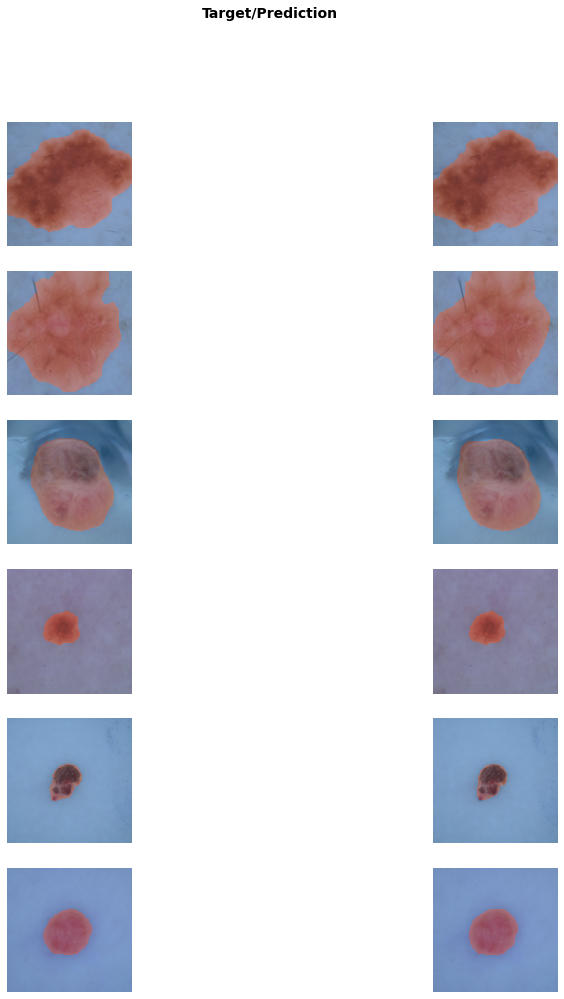

In [17]:
learn.show_results(max_n=6, figsize=(14,16))

# Training - 2

In [40]:
import gc
del dls
del learn
torch.cuda.empty_cache()
gc.collect()

53407

In [41]:
skin = DataBlock(blocks=(ImageBlock, MaskBlock(codes = codes)),
    get_items=get_image_files,
    splitter=RandomSplitter(),
    get_y=get_y,
    item_tfms=Resize(450),
    batch_tfms=[Normalize.from_stats(*imagenet_stats)])

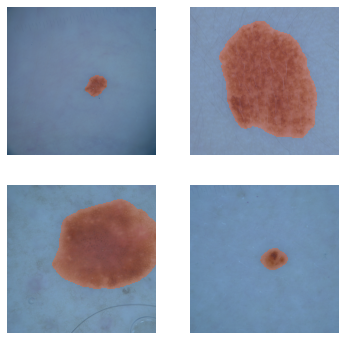

In [42]:
path = '/kaggle/input/skin-cancer-mnist-ham10000/'
dls = skin.dataloaders(path, bs=4)
dls.show_batch()

In [43]:
learn=unet_learner(dls, resnet18, metrics=iou)
learn.fine_tune(5)

epoch,train_loss,valid_loss,iou,time
0,0.136746,0.139599,0.909620,25:03


epoch,train_loss,valid_loss,iou,time
0,0.128439,0.111538,0.913502,25:54
1,0.106930,0.102924,0.925805,25:57
2,0.078877,0.083075,0.955791,25:57
3,0.063180,0.071195,0.961590,25:59
4,0.052838,0.070761,0.951921,25:57
